# Introduction

Trong kỷ nguyên thương mại điện tử, đánh giá của khách hàng (Customer Reviews) đóng vai trò then chốt. Nó không chỉ ảnh hưởng đến quyết định mua hàng của người khác mà còn chứa đựng những "insight" quý giá về chất lượng sản phẩm và trải nghiệm người dùng.

Tuy nhiên, việc phân tích thủ công hàng nghìn đánh giá là bất khả thi. Thách thức đặt ra là dữ liệu tồn tại ở hai dạng:
* **Dữ liệu phi cấu trúc (Unstructured):** Văn bản bình luận (Review Text).
* **Dữ liệu có cấu trúc (Structured):** Tuổi tác, điểm đánh giá, số lượt like...

Dự án này tập trung giải quyết bài toán trên bằng phương pháp **Hybrid Learning** (Kết hợp dữ liệu đa phương thức).

# Objective

Mục tiêu chính của đề tài là xây dựng và đánh giá các mô hình Machine Learning để dự đoán chính xác liệu một khách hàng có **KHUYÊN DÙNG (Recommend - Nhãn 1)** sản phẩm hay không **(Nhãn 0)**.

Để đạt được độ chính xác cao nhất, dự án thực hiện quy trình khoa học gồm:
1.  **Xử lý ngôn ngữ tự nhiên (NLP):** Làm sạch văn bản chuyên sâu và sử dụng TF-IDF để chuyển đổi dữ liệu văn bản thành vector số học.
2.  **Kỹ thuật Feature Engineering:** Kết hợp đặc trưng văn bản với các chỉ số số học quan trọng (Tuổi, Rating) để tăng ngữ nghĩa cho mô hình.
3.  **Xử lý mất cân bằng dữ liệu:** Áp dụng thuật toán **SMOTE** (Synthetic Minority Over-sampling Technique) để giải quyết hiện tượng lệch nhãn.
4.  **Thử nghiệm đa mô hình (Model Comparison):** Huấn luyện và so sánh hiệu năng giữa các thuật toán đại diện cho các hướng tiếp cận khác nhau: Tuyến tính **(Logistic Regression)**, Cây quyết định **(Random Forest)**, Hình học **(SVM)** và Dựa trên khoảng cách **(KNN)**.
5.  **Đánh giá toàn diện:** Sử dụng hệ thống chỉ số đa chiều gồm **Accuracy, Precision, Recall, F1-Score** và phân tích **Confusion Matrix** để lựa chọn mô hình tối ưu nhất.

# Data Understanding

Nguồn: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews/data

In [ ]:
# 1. Cài đặt thư viện xử lý mất cân bằng dữ liệu (nếu Colab chưa có)
!pip install imbalanced-learn

# 2. Thư viện xử lý dữ liệu cơ bản
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Thư viện Scikit-learn (Xử lý dữ liệu & NLP)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix # Dùng để nối ma trận thưa (Text + Số)

# 4. Thư viện Imblearn (Cân bằng dữ liệu)
from imblearn.over_sampling import SMOTE

# 5. Các mô hình Machine Learning (Bao gồm cả Ensemble)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              VotingClassifier)
from sklearn.svm import SVC

# 6. Các thước đo đánh giá (Metrics)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, matthews_corrcoef,
                             confusion_matrix, classification_report, roc_curve)

# Reading Data (EDA)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_BTL/Womens Clothing E-Commerce Reviews.csv')

# Hiển thị kích thước (Dòng, Cột)
display(df.shape)

# Hiển thị 5 dòng đầu
display(df.head())

# Hiển thị thông tin kiểu dữ liệu
df.info()

(23486, 11)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


# UNIVARIATE ANALYSIS
PHÂN TÍCH ĐƠN BIẾN

## Tỉ lệ khuyên dùng
BIểu đồ tròn, rõ tỉ lệ phần trăm

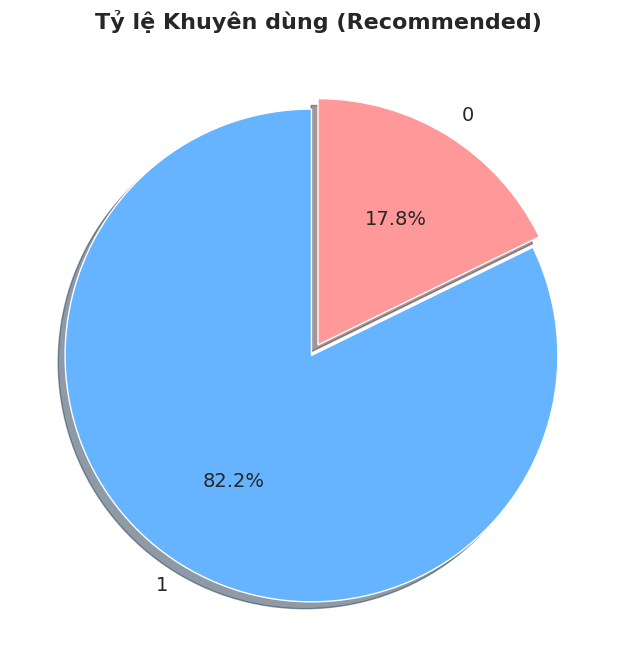

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

df['Recommended IND'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#66b3ff', '#ff9999'],
    explode=[0.05, 0],
    startangle=90,
    shadow=True,
    textprops={'fontsize': 14}
)
plt.title('Tỷ lệ Khuyên dùng (Recommended)', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.show()

## SỐ lượng khuyên dùng
Biểu đồ cột để nhìn rỗ số lượng chênh lệch

/tmp/ipython-input-3007669993.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Recommended IND', data=df, palette='pastel')


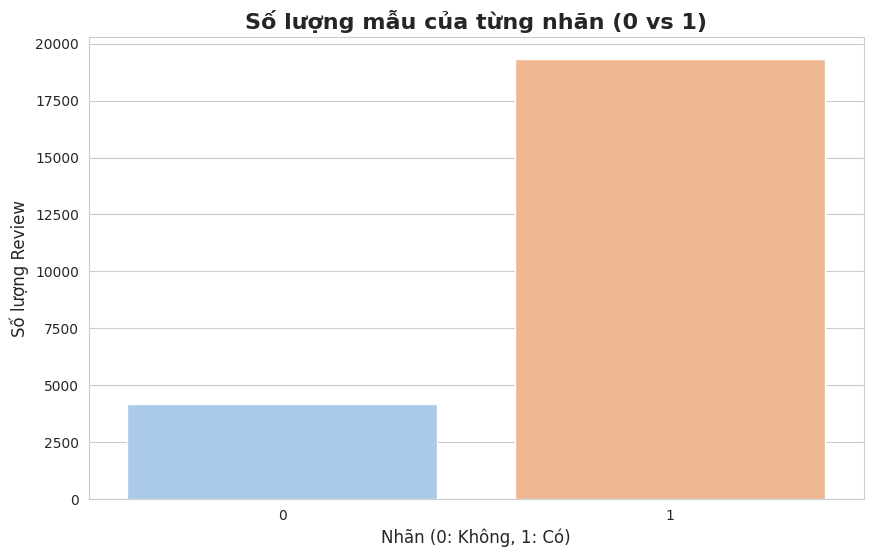

In [ ]:
plt.figure(figsize=(10, 6))

sns.countplot(x='Recommended IND', data=df, palette='pastel')

plt.title('Số lượng mẫu của từng nhãn (0 vs 1)', fontsize=16, fontweight='bold')
plt.xlabel('Nhãn (0: Không, 1: Có)', fontsize=12)
plt.ylabel('Số lượng Review', fontsize=12)
plt.show()

## Phân bố độ tuổi (Histogram)

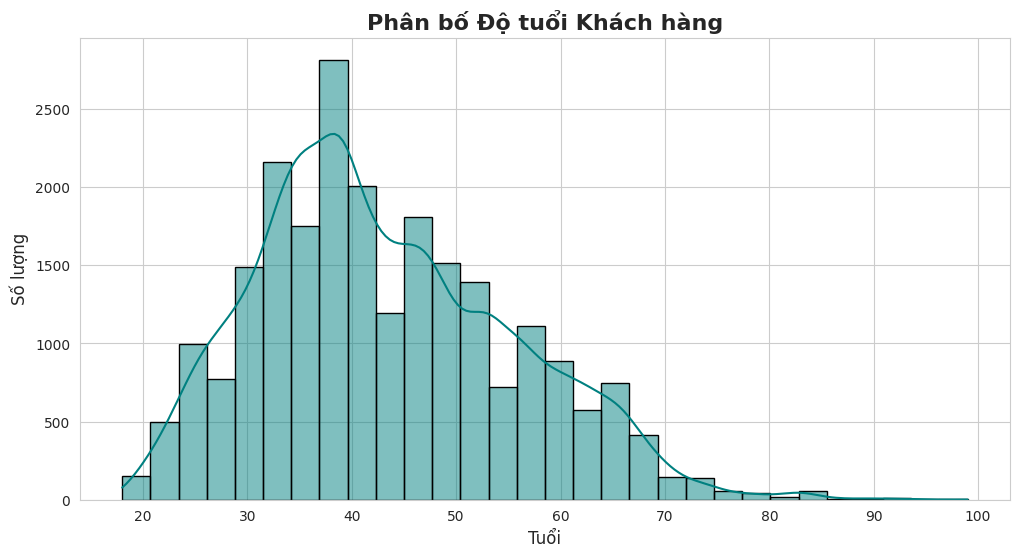

In [ ]:
plt.figure(figsize=(12, 6))

sns.histplot(df['Age'], bins=30, kde=True, color='teal', edgecolor='black')

plt.title('Phân bố Độ tuổi Khách hàng', fontsize=16, fontweight='bold')
plt.xlabel('Tuổi', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.show()

## Phân bố điểm đánh giá (Rating)

/tmp/ipython-input-3521782340.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Rating', data=df, palette='viridis')


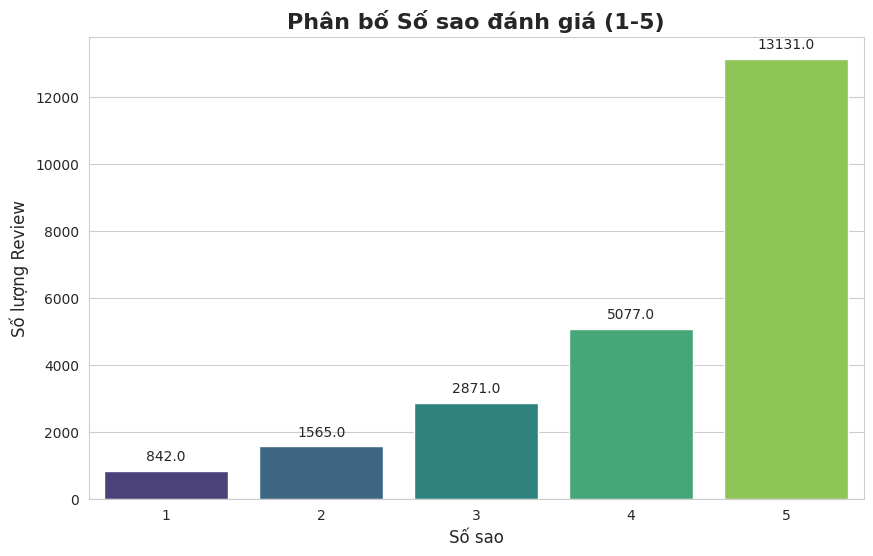

In [ ]:
plt.figure(figsize=(10, 6))

ax = sns.countplot(x='Rating', data=df, palette='viridis')

plt.title('Phân bố Số sao đánh giá (1-5)', fontsize=16, fontweight='bold')
plt.xlabel('Số sao', fontsize=12)
plt.ylabel('Số lượng Review', fontsize=12)

# Hiển thị số trên đầu cột
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

## Số lượng theo phân khúc (Division)
Xem khách hàng mua ở phân khúc nào nhiều (General, Petite...)

/tmp/ipython-input-2949002940.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Division Name', data=df, palette='Set2',


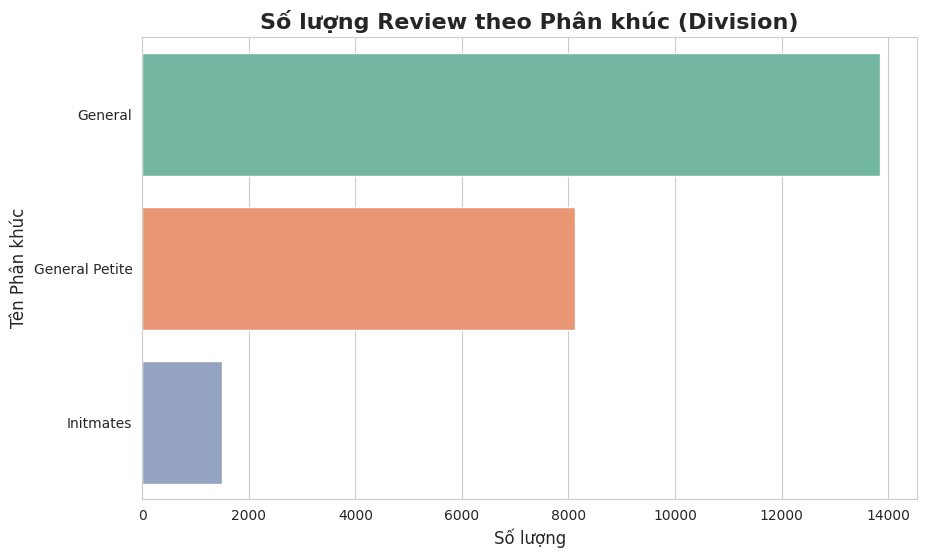

In [ ]:
plt.figure(figsize=(10, 6))

sns.countplot(y='Division Name', data=df, palette='Set2',
              order=df['Division Name'].value_counts().index)

plt.title('Số lượng Review theo Phân khúc (Division)', fontsize=16, fontweight='bold')
plt.xlabel('Số lượng', fontsize=12)
plt.ylabel('Tên Phân khúc', fontsize=12)
plt.show()

## Số lượng theo phòng ban (Department)
Khách hàng mua loại nào nhiều (Váy, Áo, Quần...)

/tmp/ipython-input-3334640651.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Department Name', data=df, palette='Set3',


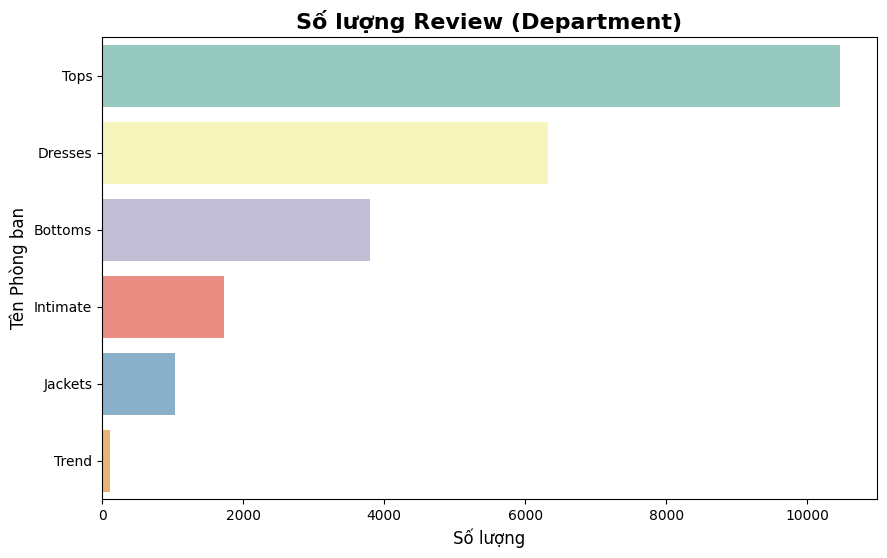

In [ ]:
plt.figure(figsize=(10, 6))

sns.countplot(y='Department Name', data=df, palette='Set3',
              order=df['Department Name'].value_counts().index)

plt.title('Số lượng Review (Department)', fontsize=16, fontweight='bold')
plt.xlabel('Số lượng', fontsize=12)
plt.ylabel('Tên Phòng ban', fontsize=12)
plt.show()

## Top 15 loại sản phẩm phổ biến nhất

/tmp/ipython-input-1205997637.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes.values, y=top_classes.index, palette='magma')


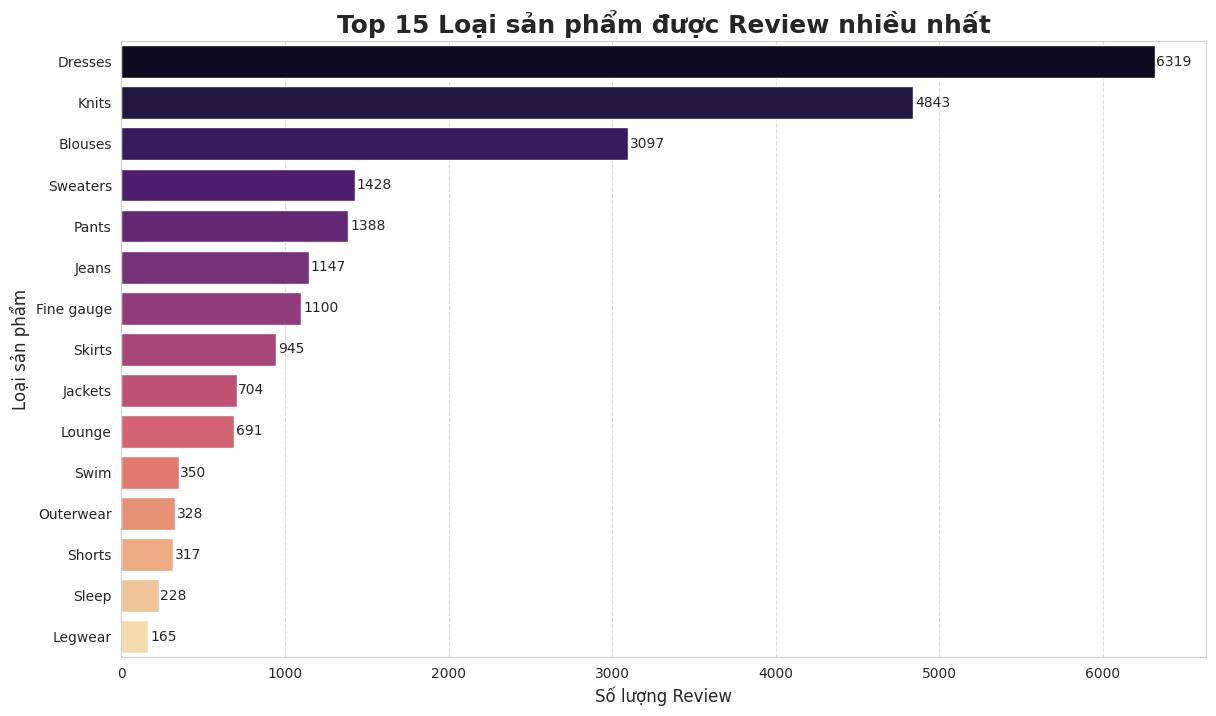

In [ ]:
plt.figure(figsize=(14, 8))

top_classes = df['Class Name'].value_counts().head(15)
sns.barplot(x=top_classes.values, y=top_classes.index, palette='magma')

plt.title('Top 15 Loại sản phẩm được Review nhiều nhất', fontsize=18, fontweight='bold')
plt.xlabel('Số lượng Review', fontsize=12)
plt.ylabel('Loại sản phẩm', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for index, value in enumerate(top_classes.values):
    plt.text(value + 10, index, str(value), va='center')

plt.show()

# BIVARIATE ANALYSIS
Phân tích quan hệ

##Tuổi tác ảnh hưởng thế nào đến quyết định Khuyên dùng?
Xem độ tuổi trung bình của người khen và người chê có khác nhau không (Box plot)

/tmp/ipython-input-1287606482.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Recommended IND', y='Age', data=df, palette='coolwarm')


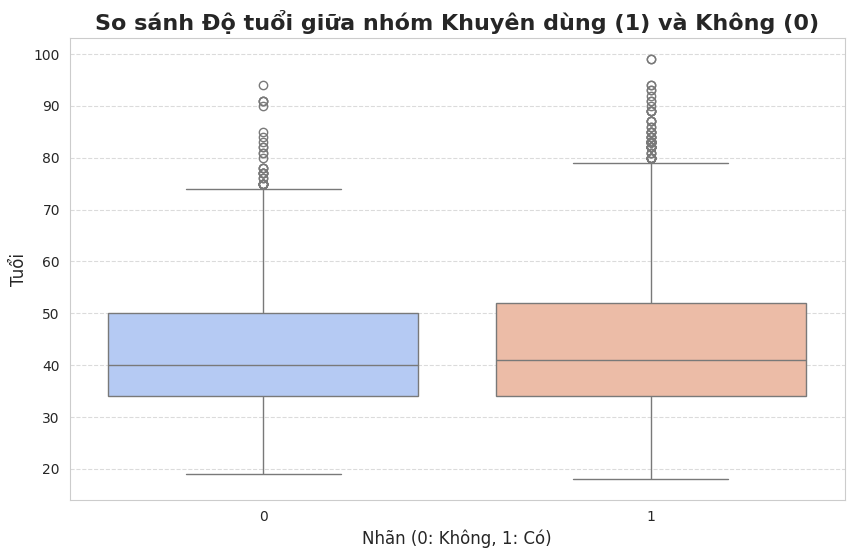

In [ ]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='Recommended IND', y='Age', data=df, palette='coolwarm')

plt.title('So sánh Độ tuổi giữa nhóm Khuyên dùng (1) và Không (0)', fontsize=16, fontweight='bold')
plt.xlabel('Nhãn (0: Không, 1: Có)', fontsize=12)
plt.ylabel('Tuổi', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Tỷ lệ đánh giá trong từng Phòng ban
Xem trong các nhóm Váy, Áo, Quần... thì nhóm nào bị chê nhiều nhất (màu đỏ)

<Figure size 1200x700 with 0 Axes>

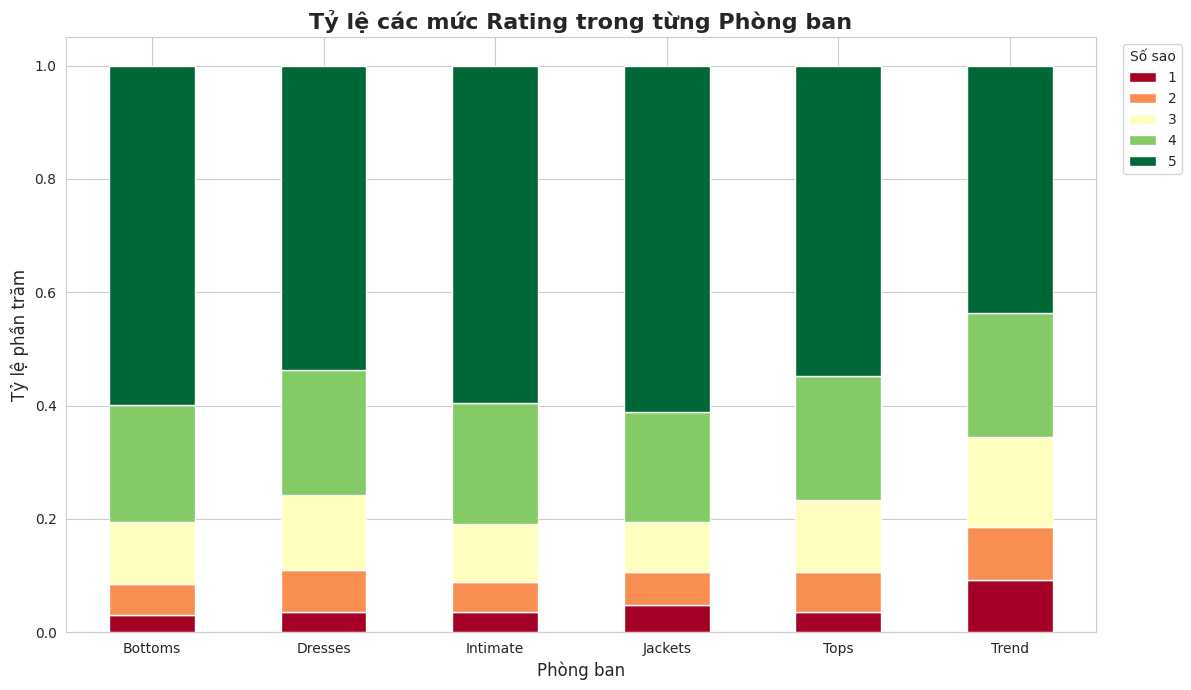

In [ ]:
plt.figure(figsize=(12, 7))

# Tạo bảng chéo và chuẩn hóa về 100%
ct = pd.crosstab(df['Department Name'], df['Rating'], normalize='index')

# Vẽ biểu đồ chồng
ct.plot(kind='bar', stacked=True, colormap='RdYlGn', figsize=(12, 7))

plt.title('Tỷ lệ các mức Rating trong từng Phòng ban', fontsize=16, fontweight='bold')
plt.xlabel('Phòng ban', fontsize=12)
plt.ylabel('Tỷ lệ phần trăm', fontsize=12)
plt.legend(title='Số sao', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Điểm đánh giá cao thì có nhiều Like không?
Xem review 5 sao hay review 1 sao thì được cộng đồng bấm Like nhiều hơn

/tmp/ipython-input-1793787213.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rating', y='Positive Feedback Count', data=df, palette='magma')


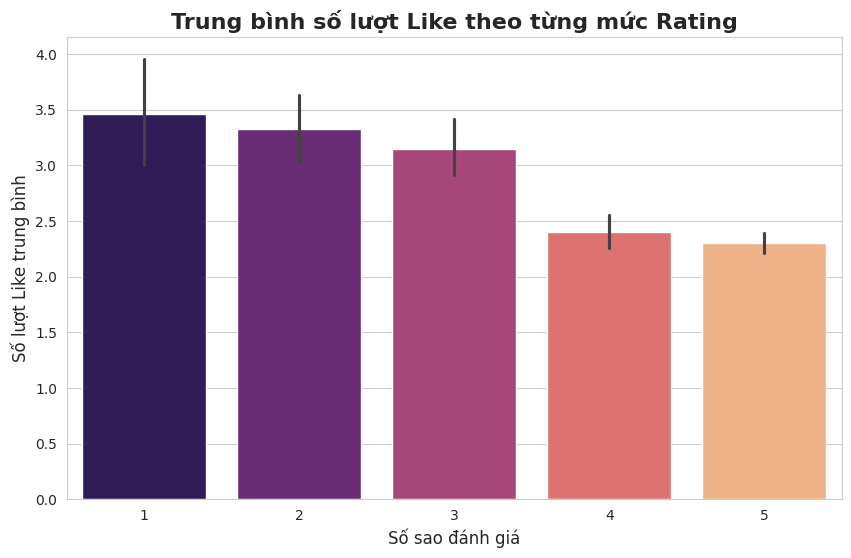

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(x='Rating', y='Positive Feedback Count', data=df, palette='magma')

plt.title('Trung bình số lượt Like theo từng mức Rating', fontsize=16, fontweight='bold')
plt.xlabel('Số sao đánh giá', fontsize=12)
plt.ylabel('Số lượt Like trung bình', fontsize=12)
plt.show()

## Độ tuổi tập trung ở mức đánh giá nào?
So sánh phân bố độ tuổi chi tiết hơn (Violin plot)

/tmp/ipython-input-3732149296.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Rating', y='Age', data=df, palette='muted')


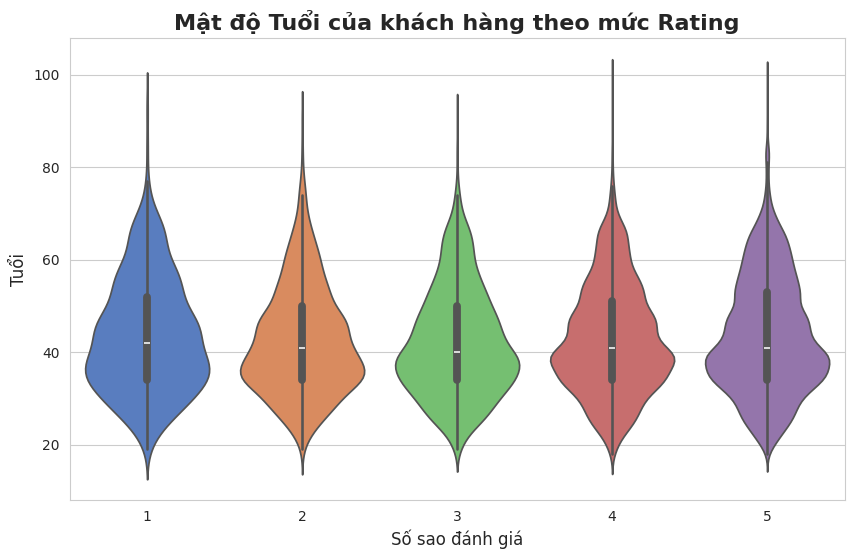

In [ ]:
plt.figure(figsize=(10, 6))

sns.violinplot(x='Rating', y='Age', data=df, palette='muted')

plt.title('Mật độ Tuổi của khách hàng theo mức Rating', fontsize=16, fontweight='bold')
plt.xlabel('Số sao đánh giá', fontsize=12)
plt.ylabel('Tuổi', fontsize=12)
plt.show()

## So sánh Rating giữa các Phân khúc
Xem hàng "General" (Thường) và "Petite" (Nhỏ) bên nào được đánh giá tốt hơn

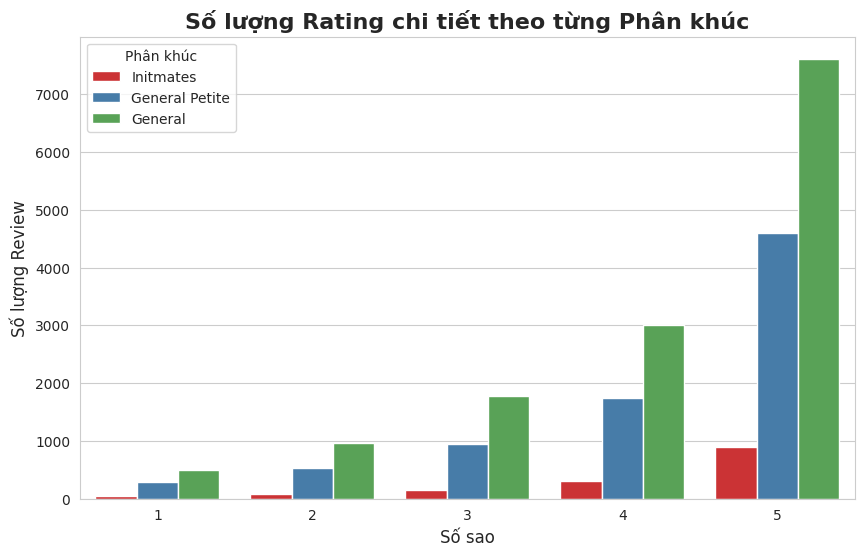

In [ ]:
plt.figure(figsize=(10, 6))

sns.countplot(x='Rating', hue='Division Name', data=df, palette='Set1')

plt.title('Số lượng Rating chi tiết theo từng Phân khúc', fontsize=16, fontweight='bold')
plt.xlabel('Số sao', fontsize=12)
plt.ylabel('Số lượng Review', fontsize=12)
plt.legend(title='Phân khúc')
plt.show()

# CORRELATION
Phân tích tương quan

## Ma trận tương quan (Heatmap)

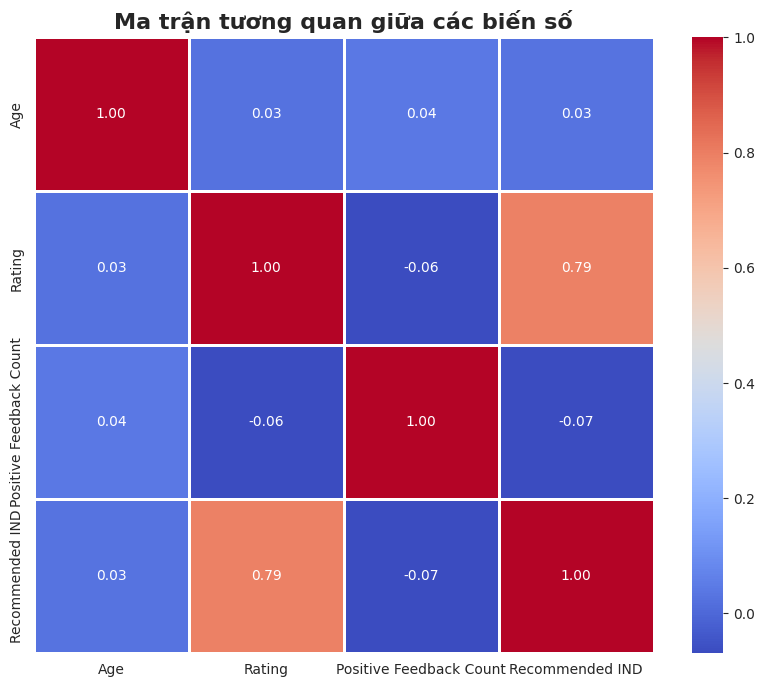

In [ ]:
plt.figure(figsize=(10, 8))

# Chỉ chọn các cột số để tính tương quan
numeric_cols = ['Age', 'Rating', 'Positive Feedback Count', 'Recommended IND']

# Vẽ Heatmap
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)

plt.title('Ma trận tương quan giữa các biến số', fontsize=16, fontweight='bold')
plt.show()

#WORDCLOUD

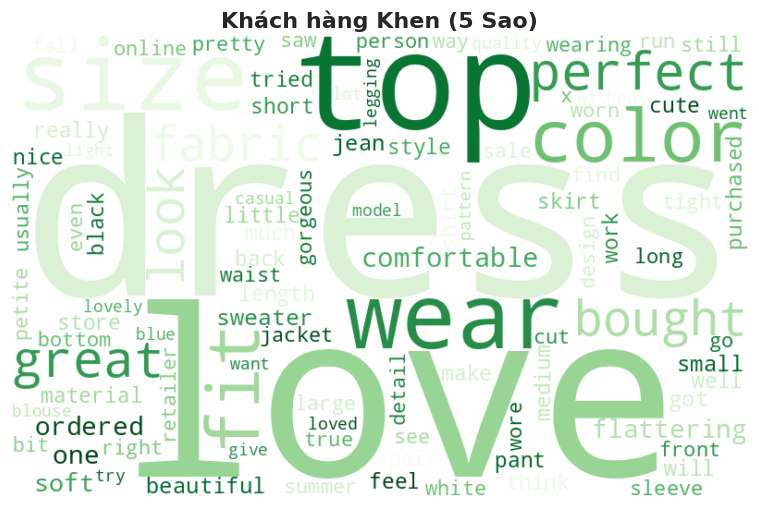

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# --- KHÁCH KHEN (5 SAO) ---
plt.figure(figsize=(10, 6)) # Thiết lập khung hình riêng

# Lọc review 5 sao
text_good = " ".join(review for review in df[df['Rating']==5]['Review Text'].astype(str))

# Tạo WordCloud
wc_good = WordCloud(background_color='white', max_words=100, colormap='Greens', width=800, height=500).generate(text_good)

# Hiển thị
plt.imshow(wc_good, interpolation='bilinear')
plt.axis('off')
plt.title('Khách hàng Khen (5 Sao)', fontsize=16, fontweight='bold')
plt.show() # Hiển thị hình này xong rồi mới chạy code hình dưới

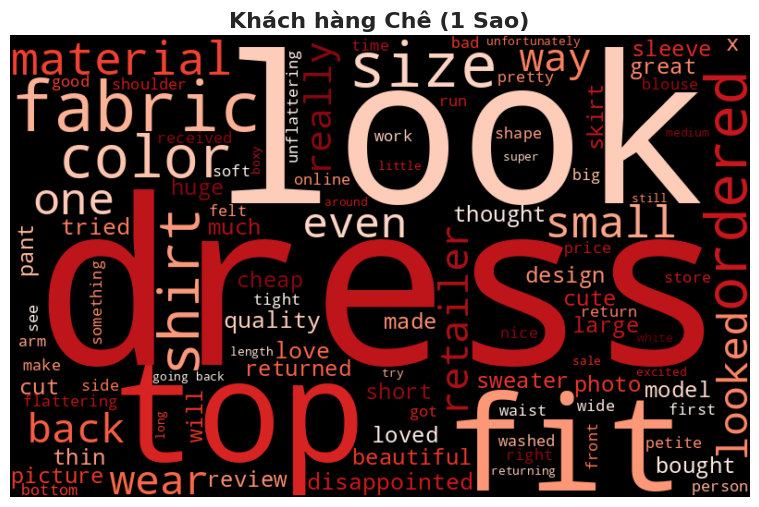

In [ ]:
# --- KHÁCH CHÊ (1 SAO) ---
plt.figure(figsize=(10, 6)) # Thiết lập khung hình riêng mới

# Lọc review 1 sao
text_bad = " ".join(review for review in df[df['Rating']==1]['Review Text'].astype(str))

# Tạo WordCloud
wc_bad = WordCloud(background_color='black', max_words=100, colormap='Reds', width=800, height=500).generate(text_bad)

# Hiển thị
plt.imshow(wc_bad, interpolation='bilinear')
plt.axis('off')
plt.title('Khách hàng Chê (1 Sao)', fontsize=16, fontweight='bold')
plt.show()

# DATA CLEANING
Loại bỏ thông tin thừa

In [ ]:
# 1. Xóa các cột không cần thiết
# LƯU Ý QUAN TRỌNG: Giữ lại cột 'Title' để lát nữa gộp vào Review Text
# Chỉ xóa 'Unnamed: 0' (rác) và 'Clothing ID' (mã sản phẩm nhiễu)
cols_to_drop = ['Unnamed: 0', 'Clothing ID']

# Kiểm tra và xóa
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)

# 2. Xóa các dòng bị thiếu dữ liệu (Missing Values)
# Chỉ xóa nếu thiếu Review Text hoặc thông tin phân loại quan trọng
df_clean = df.dropna(subset=['Review Text', 'Division Name', 'Department Name', 'Class Name'])

# 3. Hiển thị kết quả
print(f"Kích thước ban đầu: {df.shape}")
print(f"Kích thước sau khi làm sạch: {df_clean.shape}")
print(f"-> Đã loại bỏ {df.shape[0] - df_clean.shape[0]} dòng lỗi.")

# Hiển thị lại dữ liệu sạch để kiểm tra (Vẫn còn cột Title là ĐÚNG)
display(df_clean.head())

Kích thước ban đầu: (23486, 9)
Kích thước sau khi làm sạch: (22628, 9)
-> Đã loại bỏ 858 dòng lỗi.


,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


# DATA PREPROCESSING
Tiền xử lý

## TEXT CLEANING
Làm sạch văn bản: Chỉ xử lý chuỗi và hiển thị bảng kết quả cuối cùng

In [ ]:
# 1. Gộp Title và Review Text
df_clean['Title'] = df_clean['Title'].fillna('')
df_clean['Full_Text'] = df_clean['Title'] + " " + df_clean['Review Text']

# 2. Định nghĩa hàm làm sạch
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\n', ' ', text)
    return text

# 3. Áp dụng hàm
df_clean['Cleaned_Text'] = df_clean['Full_Text'].apply(clean_text)

# Hiển thị kết quả
df_clean[['Full_Text', 'Cleaned_Text']].head()

/tmp/ipython-input-3038726268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Title'] = df_clean['Title'].fillna('')
/tmp/ipython-input-3038726268.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Full_Text'] = df_clean['Title'] + " " + df_clean['Review Text']
/tmp/ipython-input-3038726268.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,Full_Text,Cleaned_Text
0,Absolutely wonderful - silky and sexy and com...,absolutely wonderful silky and sexy and comf...
1,Love this dress! it's sooo pretty. i happen...,love this dress its sooo pretty i happened ...
2,Some major design flaws I had such high hopes ...,some major design flaws i had such high hopes ...
3,"My favorite buy! I love, love, love this jumps...",my favorite buy i love love love this jumpsuit...
4,Flattering shirt This shirt is very flattering...,flattering shirt this shirt is very flattering...


## TF-IDF
Vector hóa: Biến đổi văn bản thành ma trận số

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Cấu hình TF-IDF (Lấy 2000 từ quan trọng nhất, cả từ đơn và cụm 2 từ)
tfidf = TfidfVectorizer(max_features=2000, stop_words='english', ngram_range=(1, 2))

# Thực hiện chuyển đổi
X_text = tfidf.fit_transform(df_clean['Cleaned_Text'])

# Hiển thị kích thước ma trận văn bản
X_text.shape

(22628, 2000)

## ENCODING & SCALING
Mã hóa và chuẩn hóa: Xử lý dữ liệu phân loại và số học, sau đó gộp tất cả lại)

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# 1. Mã hóa dữ liệu phân loại (One-Hot Encoding)
X_cat = pd.get_dummies(df_clean[['Division Name', 'Department Name', 'Class Name']], drop_first=True)
X_cat_sparse = csr_matrix(X_cat.values)

# 2. Chuẩn hóa dữ liệu số (Scaling)
scaler = StandardScaler()
# Tạo cột độ dài review (nếu chưa có)
df_clean['Review_Len'] = df_clean['Full_Text'].apply(len)
X_num = scaler.fit_transform(df_clean[['Age', 'Rating', 'Positive Feedback Count', 'Review_Len']])

# 3. GỘP TẤT CẢ LẠI (Văn bản + Số + Phân loại)
X_final = hstack([X_text, X_num, X_cat_sparse])
y = df_clean['Recommended IND']

# Hiển thị kích thước dữ liệu cuối cùng (Dòng, Cột)
X_final.shape

/tmp/ipython-input-2204719748.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Review_Len'] = df_clean['Full_Text'].apply(len)


(22628, 2030)

## Smote
Chia tập và cân bằng: Chia train/test và xử lý dữ liệu lệch)

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. Chia tập Train - Test (Tỷ lệ 80-20)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# 2. Áp dụng SMOTE để cân bằng dữ liệu (Chỉ áp dụng trên tập Train)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Hiển thị số lượng mẫu sau khi cân bằng
y_train_res.value_counts()

,count
Recommended IND,
1,14846
0,14846


# Trực quan hóa dữ liệu trước và sau khi cân bằng

/tmp/ipython-input-2880400032.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Reds')
/tmp/ipython-input-2880400032.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, palette='Greens')


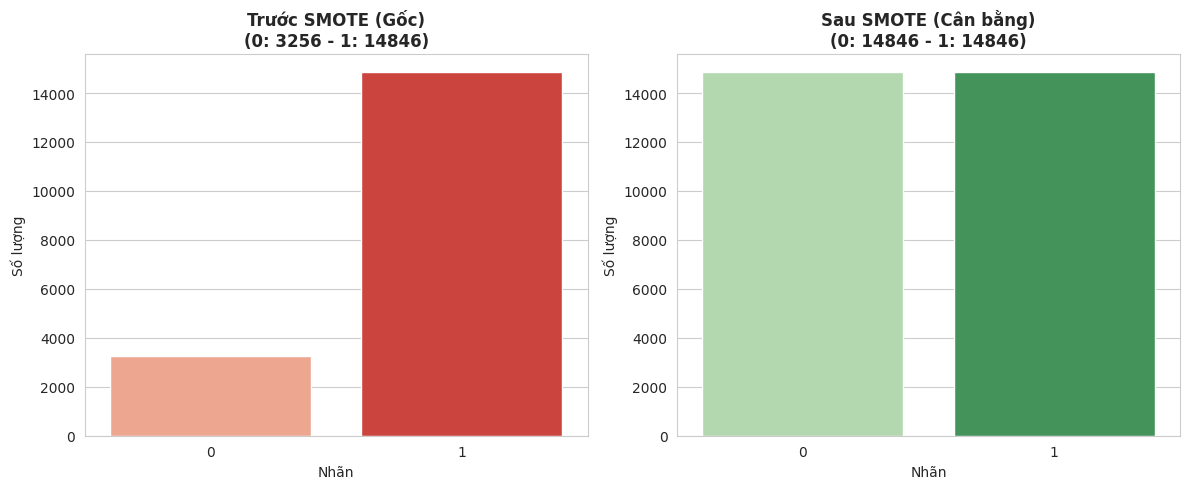

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# --- BIỂU ĐỒ 1: TRƯỚC KHI SMOTE (Dữ liệu gốc) ---
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette='Reds')
# Hiển thị số lượng cụ thể trên tiêu đề để dễ so sánh
plt.title(f'Trước SMOTE (Gốc)\n(0: {sum(y_train==0)} - 1: {sum(y_train==1)})', fontsize=12, fontweight='bold')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')

# --- BIỂU ĐỒ 2: SAU KHI SMOTE (Dữ liệu cân bằng) ---
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_res, palette='Greens')
plt.title(f'Sau SMOTE (Cân bằng)\n(0: {sum(y_train_res==0)} - 1: {sum(y_train_res==1)})', fontsize=12, fontweight='bold')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

#Huấn luyện mô hình và đánh giá mô hình

##Khai báo thư viện và cấu hình cho mô hình

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

##Logistic Regression

In [ ]:
# Khởi tạo và fit vào dữ liệu đã cân bằng (SMOTE)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

##Random Forest

In [ ]:
# Sử dụng 100 cây quyết định
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

##Support Vector Machine - SVM

In [ ]:
# probability=True để sau này có thể vẽ đường ROC
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_res, y_train_res)

SVC(kernel='linear', probability=True, random_state=42)

##K-Nearest Neighbors - KNN

In [ ]:
# Chọn k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res, y_train_res)

KNeighborsClassifier()

##Nhận xét
- Các mô hình Logistic Regression, Random Forest, SVM và KNN đều đã được huấn luyện thành công trên tập dữ liệu
- Dữ liệu đầu vào đã được xử lý qua TF-IDF và cân bằng bằng SMOTE, đảm bảo các mô hình học được đặc trưng của cả hai nhóm khách hàng (Khen và Chê) một cách công bằng
- Các mô hình này hiện đã sẵn sàng để chuyển sang giai đoạn kiểm thử trên tập dữ liệu thực tế (X_test)

# Đánh giá mô hình

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_plot(model, X_test, y_test, model_name):
    # 1. Dự đoán
    y_pred = model.predict(X_test)

    # 2. In kết quả
    print(f"MODEL: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    # 3. Vẽ Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

##Đánh giá Logistic Regression

MODEL: Logistic Regression
Accuracy: 0.9428
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       845
           1       0.99      0.94      0.96      3681

    accuracy                           0.94      4526
   macro avg       0.89      0.94      0.91      4526
weighted avg       0.95      0.94      0.94      4526



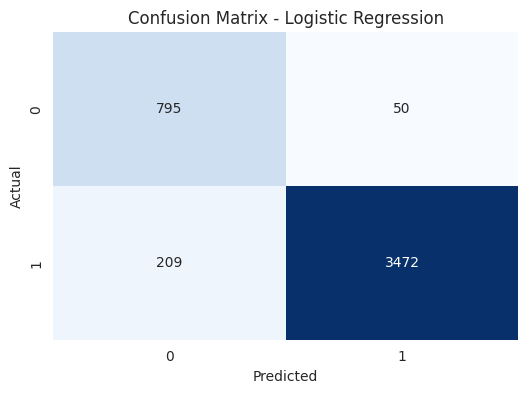

In [ ]:
evaluate_and_plot(log_reg, X_test, y_test, "Logistic Regression")

Nhận xét:

Độ chính xác tổng thể (Accuracy): Cao nhất, đạt 94.28%.

Khả năng phát hiện lớp thiểu số (Class 0): Rất ấn tượng:
+ Recall đạt 94%, nghĩa là nó bắt được hầu hết các trường hợp Class 0 thực tế.
+ Precision đạt 79%, một con số khá tốt, cho thấy khi nó dự đoán là 0 thì độ tin cậy khá cao.

Confusion Matrix: Chỉ bỏ sót 50 trường hợp Class 0 (False Negative) và đoán nhầm 209 trường hợp Class 1 (False Positive).
KẾT LUẬN: Mô hình cân bằng và mạnh mẽ nhất.

##Đánh giá Random Forest

MODEL: Random Forest
Accuracy: 0.9399
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       845
           1       0.98      0.95      0.96      3681

    accuracy                           0.94      4526
   macro avg       0.89      0.92      0.91      4526
weighted avg       0.94      0.94      0.94      4526



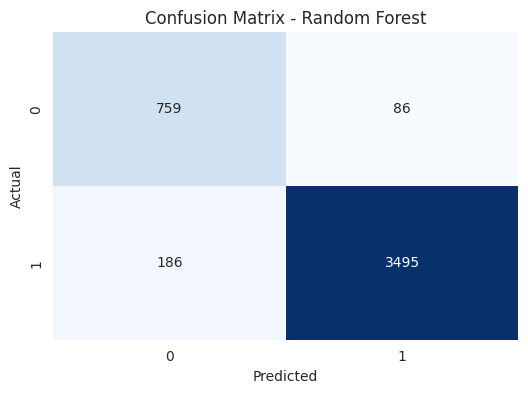

In [ ]:
evaluate_and_plot(rf, X_test, y_test, "Random Forest")

Nhận xét:

Mô hình hoạt động rất tốt, bám sát Logistic Regression.

Độ chính xác tổng thể (Accuracy): Đạt 93.99%, chỉ thua LR một chút không đáng kể.

So sánh với Logistic Regression về Class 0:
+ Precision nhỉnh hơn một chút (0.80 so với 0.79 của LR).
+ Nhưng Recall lại thấp hơn (0.90 so với 0.94 của LR).
-> Nghĩa là RF "thận trọng" hơn LR khi dự đoán Class 0. Nó ít đoán sai hơn, nhưng lại bỏ sót nhiều hơn (86 trường hợp sót so với 50 của LR).

-> KẾT LUẬN: Một lựa chọn thay thế tuyệt vời, hiệu suất rất cao.

##Đánh giá SVM

MODEL: Support Vector Machine
Accuracy: 0.9381
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       845
           1       0.98      0.94      0.96      3681

    accuracy                           0.94      4526
   macro avg       0.88      0.93      0.90      4526
weighted avg       0.94      0.94      0.94      4526



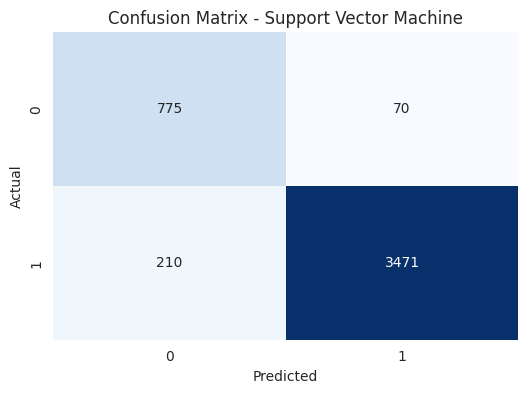

In [ ]:
evaluate_and_plot(svm, X_test, y_test, "Support Vector Machine")

Nhận xét:

Kết quả của SVM gần như là anh em sinh đôi với Logistic Regression.

Độ chính xác tổng thể (Accuracy): 93.81%, rất cao.

Các chỉ số chi tiết (Precision/Recall cho Class 0):
+ Precision 0.79, Recall 0.92. Các con số này gần như tương đồng với LR (0.79 và 0.94).

KẾT LUẬN: SVM hoạt động rất hiệu quả trên tập dữ liệu này, chứng tỏ dữ liệu có khả năng phân tách tốt trong không gian nhiều chiều.

##Đánh giá KNN

MODEL: K-Nearest Neighbors
Accuracy: 0.8760
              precision    recall  f1-score   support

           0       0.61      0.96      0.74       845
           1       0.99      0.86      0.92      3681

    accuracy                           0.88      4526
   macro avg       0.80      0.91      0.83      4526
weighted avg       0.92      0.88      0.89      4526



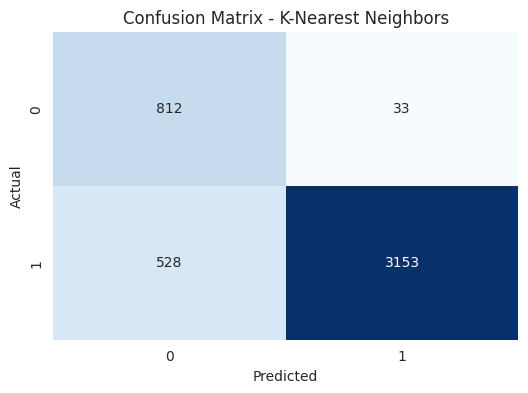

In [ ]:
evaluate_and_plot(knn, X_test, y_test, "K-Nearest Neighbors")

Nhận xét:

Đây là mô hình có kết quả "lạ" nhất và thấp nhất.

Độ chính xác tổng thể (Accuracy): Chỉ đạt 87.60%, thấp nhất trong nhóm.

Điểm đặc biệt (Sự đánh đổi cực đoan):
+ Recall Class 0 CỰC CAO (96%): Nó là thằng giỏi nhất trong việc tìm ra Class 0.
+ Precision Class 0 CỰC THẤP (61%): Nó dự đoán là 0 quá bừa bãi.

Nhìn Confusion Matrix để hiểu rõ: Nó dự đoán sai một lượng khổng lồ Class 1 sang Class 0 (528 trường hợp - False Positive cao nhất). Chính điều này kéo tụt độ chính xác.

-> KẾT LUẬN: KNN không phù hợp cho bài toán này do hiệu suất tổng thể kém và bị lệch (bias) quá nhiều về việc dự đoán Class 0.

#Demo

In [ ]:
import numpy as np
from scipy.sparse import hstack
import warnings
warnings.filterwarnings("ignore") # Tắt mấy cái cảnh báo đỏ lòm cho đỡ rối mắt

def run_smart_demo():
    print("="*70)
    print("🤖 HỆ THỐNG DỰ ĐOÁN REVIEW (AUTO-FIX MODE)")
    print("👉 Nhập thông tin để AI dự đoán.")
    print("👉 Gõ 'exit' để thoát.")
    print("="*70)

    while True:
        try:
            # --- 1. NHẬP LIỆU ---
            text_input = input("\n📝 Nhập Review (Tiếng Anh): ")
            if text_input.lower() in ['exit', 'quit']:
                print("👋 Tạm biệt!")
                break
            if not text_input.strip(): continue

            print("   (Nhập số liệu hỗ trợ)")
            age_input = float(input("   🎂 Nhập Tuổi (VD: 18): "))
            rating_input = float(input("   ⭐ Nhập Rating (1-5): "))

            fb_str = input("   👍 Số like (Enter = 0): ")
            feedback_input = float(fb_str) if fb_str.strip() else 0.0

            # --- 2. XỬ LÝ DỮ LIỆU THÔNG MINH ---

            # B1: Xử lý văn bản
            clean = clean_text(text_input)
            text_vec = tfidf.transform([clean])

            # B2: Xử lý số liệu (Tự động sửa lỗi thiếu cột)
            # Danh sách gốc 3 món
            features_list = [age_input, rating_input, feedback_input]

            # Kiểm tra xem Scaler cần bao nhiêu cột
            if 'scaler' in globals():
                expected_cols = scaler.n_features_in_ # Số cột scaler đã học (VD: 4)
                current_cols = len(features_list)     # Số cột mình nhập (3)

                # Nếu thiếu, ta thử bổ sung
                if expected_cols > current_cols:
                    missing = expected_cols - current_cols
                    # Giả thuyết 1: Cột thiếu là "Độ dài review" (Rất phổ biến)
                    review_length = len(clean.split())
                    features_list.append(review_length) # Thêm độ dài vào

                    # Nếu vẫn còn thiếu nữa (missing > 1), điền số 0 nốt
                    if len(features_list) < expected_cols:
                        features_list.extend([0] * (expected_cols - len(features_list)))

                # Chuyển thành numpy array
                num_features = np.array([features_list])

                # Scale dữ liệu
                num_features = scaler.transform(num_features)
            else:
                # Nếu không dùng scaler, cứ dùng số thô
                num_features = np.array([features_list])

            # B3: Gộp Text + Số + Các cột One-hot còn thiếu
            # Tính tổng số cột mà Model cần (VD: 2000 cột TF-IDF + 4 cột số + các cột One-hot)
            # Lấy vector mẫu từ tập Train để biết kích thước chuẩn

            # Gộp tạm Text + Số
            current_vec = hstack([text_vec, num_features])

            # Tính số cột Dummy (One-hot) còn thiếu
            total_train_cols = X_train_res.shape[1]
            missing_dummy_cols = total_train_cols - current_vec.shape[1]

            if missing_dummy_cols > 0:
                dummy_cat = np.zeros((1, missing_dummy_cols))
                input_vec = hstack([current_vec, dummy_cat])
            else:
                input_vec = current_vec

            # --- 3. DỰ ĐOÁN ---
            print("-" * 65)
            print(f"{'MÔ HÌNH':<25} | {'DỰ ĐOÁN':<15} | {'ĐỘ TIN CẬY'}")
            print("-" * 65)

            models_demo = [
                ('Logistic Regression', log_reg),
                ('Random Forest', rf),
                ('SVM', svm),
                ('KNN', knn)
            ]

            for name, model in models_demo:
                pred = model.predict(input_vec)[0]
                label = "👍 KHUYÊN DÙNG" if pred == 1 else "👎 KHÔNG KHUYÊN"

                try:
                    prob = model.predict_proba(input_vec)[0]
                    confidence = f"{max(prob)*100:.1f}%"
                except:
                    confidence = "---"

                print(f"{name:<25} | {label:<15} | {confidence}")
            print("-" * 65)

        except Exception as e:
            print(f"\n❌ Lỗi vẫn còn: {e}")
            print("👉 Nguyên nhân: Cấu trúc dữ liệu lúc Train và Demo quá khác biệt.")
            print("👉 Giải pháp: Bạn hãy nhập lại ô input bên dưới.")

# Gọi hàm
run_smart_demo()

🤖 HỆ THỐNG DỰ ĐOÁN REVIEW (AUTO-FIX MODE)
👉 Nhập thông tin để AI dự đoán.
👉 Gõ 'exit' để thoát.

📝 Nhập Review (Tiếng Anh): I love this dress so much! The fabric is soft and fits perfectly.
   (Nhập số liệu hỗ trợ)
   🎂 Nhập Tuổi (VD: 18): 18
   ⭐ Nhập Rating (1-5): 5
   👍 Số like (Enter = 0): 
-----------------------------------------------------------------
MÔ HÌNH                   | DỰ ĐOÁN         | ĐỘ TIN CẬY
-----------------------------------------------------------------
Logistic Regression       | 👍 KHUYÊN DÙNG   | 99.8%
Random Forest             | 👍 KHUYÊN DÙNG   | 97.0%
SVM                       | 👍 KHUYÊN DÙNG   | 100.0%
KNN                       | 👍 KHUYÊN DÙNG   | 100.0%
-----------------------------------------------------------------

📝 Nhập Review (Tiếng Anh): Terrible quality. The material feels cheap and it ripped after one wash.
   (Nhập số liệu hỗ trợ)
   🎂 Nhập Tuổi (VD: 18): 23
   ⭐ Nhập Rating (1-5): 1
   👍 Số like (Enter = 0): 
--------------------------------